In [1]:
import torch
import umap.umap_ as umap
import numpy as np
import pandas as pd
import sklearn
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  
        
seed = 42
setup_seed(seed=seed)

In [ ]:
expr=pd.read_csv('Data/2.2/expr.csv').iloc[:,1:]
meta=pd.read_csv("Data/2.2/stateFate_inVitro_metadata.csv")
scaler = StandardScaler()
scaler.fit(expr[meta['Time point']!=4])
xs = pd.DataFrame(scaler.transform(expr), index = expr.index, columns = expr.columns)
pca = sklearn.decomposition.PCA(n_components = 50)
pca.fit(xs[meta['Time point']!=4].values)

xp = pd.DataFrame(pca.transform(xs))
# xp = pd.DataFrame(pca.fit_transform(xs))
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 50)
data_day2=torch.from_numpy(xp[meta['Time point']==2].values)
data_day4=torch.from_numpy(xp[meta['Time point']==4].values)
data_day6=torch.from_numpy(xp[meta['Time point']==6].values)
x_seq=torch.cat([data_day2,data_day4,data_day6])
um.fit(torch.cat([data_day2,data_day6]))
xu = um.transform(x_seq)

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [4]:
from scope import computations as cmp
from scope import clustering as cl
from scope import pre_match as pm
from scope import visualizations as vi

data_lst = [data_day2,data_day6]
time_steps = [2,6]

cluster_centers, labels_list, best_k = cl.kmeans_auto([d.cuda() for d in data_lst],tol=1e-4,method='calinski_harabasz',max_k=8)
print(best_k)

max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences(data_lst)
print(max_variance_differences)

# scal = cmp.eps_scalar()
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.95,min_eps=0.1)

[2, 4]
[46.82389616924064]


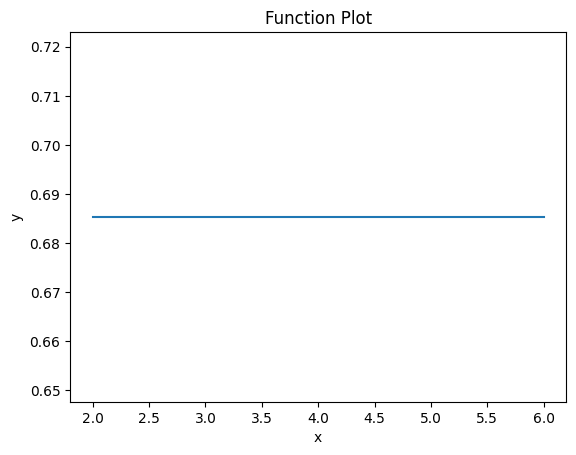

In [5]:
x = np.linspace(time_steps[0], time_steps[-1], 400)

y = [eps_func(x_i) for x_i in x]

plt.plot(x, y)

plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

2-6模型

processed: 37:  92%|█████████▎| 37/40 [03:32<00:17,  5.75s/it, loss=188.28340602208033, loss_fore=192.13065621298512, loss_back=184.43615583117528]


Early stopping at epoch 37


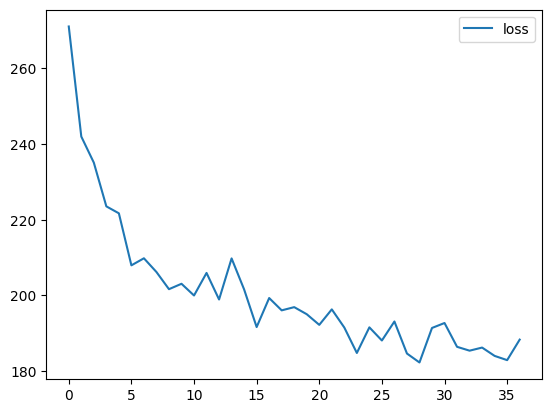

processed: 40: 100%|██████████| 40/40 [1:11:30<00:00, 107.27s/it, loss=129.58750592179706, loss_back=129.58750592179706]


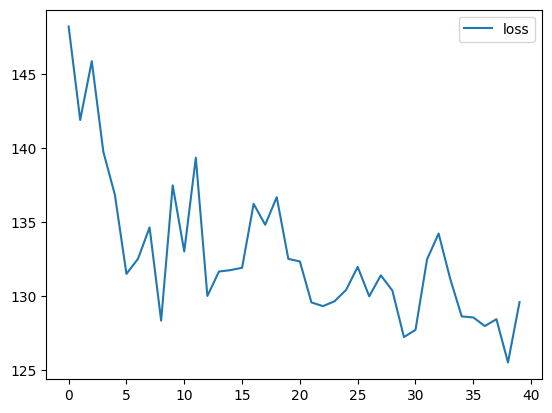

In [6]:
import scope
from scope import model
steps = 128
eps = eps_func

eps_test = eps_func
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=40,N_finetuning=40,backbone_lr=1e-3,finetuning_lr=1e-3,
                              steps=steps,eps=eps,early_stop=True,patience=8,B=128,lambda_=1e-3,save=True,record_gap=1,save_path='model_history/weinreb_interpolation_no_prematch',
                              prematched=False)
sb_object.backbone_train()
sb_object.fine_tune(change=4)

In [7]:
fore_base=sb_object.eval_fore(data_day2.cuda().double(),sb_object.v_fore)
fore_ft=sb_object.eval_fore(data_day2.cuda().double(),sb_object.v_fore_fine_tuned)

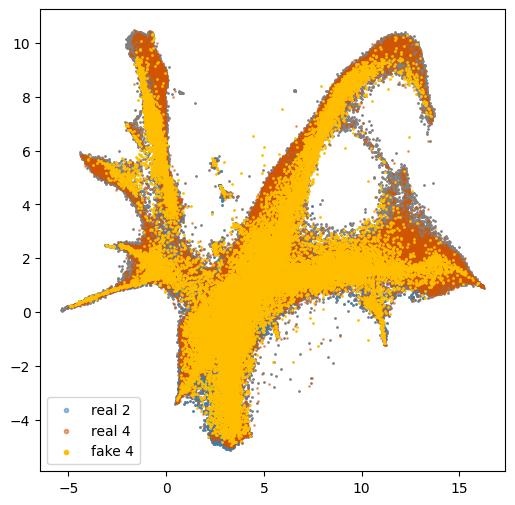

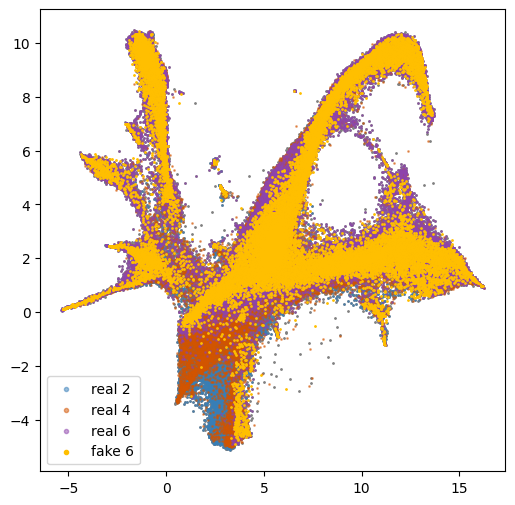

In [11]:
vi.visualize_generated_populations([data_day2,data_day4,data_day6],fore_base,[2,4,6],umap_model=um,save_path='./weinreb_interpolation_results_no_prematch/generated_populations')

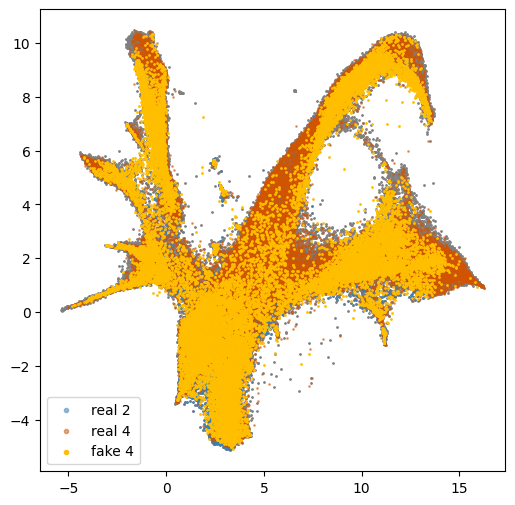

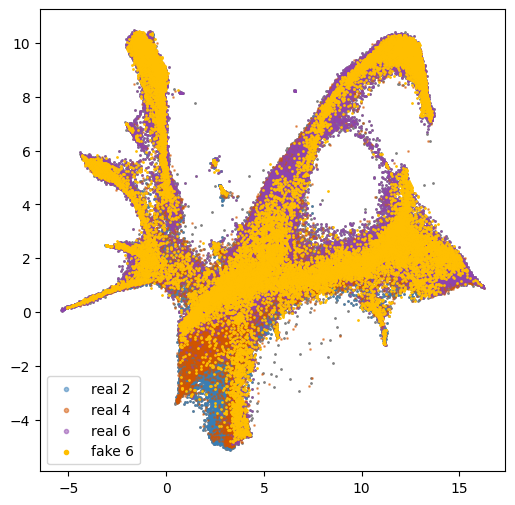

In [12]:
vi.visualize_generated_populations([data_day2,data_day4,data_day6],fore_ft,[2,4,6],umap_model=um,save_path='./weinreb_interpolation_results_no_prematch/generated_populations_fine_tuned')

In [10]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7,backend='auto')
tensor1 = torch.tensor(data_day4, dtype=torch.float32).contiguous().cuda()
tensor2 = torch.tensor(data_day6, dtype=torch.float32).contiguous().cuda()
tensor3 = torch.tensor(fore_base[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
tensor4 = torch.tensor(fore_base[-1], dtype=torch.float32).contiguous().cuda()
tensor5 = torch.tensor(fore_ft[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
tensor6 = torch.tensor(fore_ft[-1], dtype=torch.float32).contiguous().cuda()
print("backbone real4-fake4",ot_solver(tensor1[np.random.choice(data_day4.shape[0],10000),:], tensor3).item())
print("backbone real6-fake6",ot_solver(tensor2[np.random.choice(data_day6.shape[0],10000),:], tensor4).item())
print("finetuned real4-fake4",ot_solver(tensor1[np.random.choice(data_day4.shape[0],10000),:], tensor5).item())
print("finetuned real6-fake6",ot_solver(tensor2[np.random.choice(data_day6.shape[0],10000),:], tensor6).item())

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [c-1/2*(d*Sum((a-b)**2)),1] with a=Var(0,50,0), b=Var(1,50,1), c=Var(2,1,1), d=Var(3,1,2) ... 

/tmp/ipykernel_816/2662554511.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor1 = torch.tensor(data_day4, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_816/2662554511.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor2 = torch.tensor(data_day6, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_816/2662554511.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor3 = torch.tensor(fore_base[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_816/2662554511.py:6: UserWarning: To co

OK
backbone real4-fake4 48.191810607910156
backbone real6-fake6 33.260162353515625
finetuned real4-fake4 51.44428634643555
finetuned real6-fake6 47.487300872802734
